In [4]:
!pip install xpatterns

  Could not find a version that satisfies the requirement xpatterns (from versions: )
No matching distribution found for xpatterns
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Create the spark context and import some libraries

In [1]:
%matplotlib inline
import numpy as np
import datetime
from pylab import *
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import pyspark
import xpatterns.configuration 
from xpatterns.analytics.dal import DAL
sc = pyspark.SparkContext(master = xpatterns.configuration.XPATTERNS_ANALYTICS_SPARK_MASTER)
hc = pyspark.sql.HiveContext(sc)
d = DAL(use_shark=False)

ImportError: No module named 'xpatterns'

#### Convert the table produced by XLP in Parquet format

In [2]:
hc.sql('DROP TABLE strata.mimic2_p')
hc.sql('SET spark.sql.parquet.cacheMetadata = true')
hc.sql('SET spark.sql.parquet.compression.codec = snappy')
hc.sql('CREATE TABLE strata.mimic2_p STORED AS PARQUET AS SELECT * FROM strata.annotations_mimic2_strata')
hc.sql('USE strata')
#hc.sql('CACHE TABLE mimic2_p')

DataFrame[result: string]

#### View the data coming out of XLP

In [3]:
df = d.execute_query('SELECT * FROM strata.mimic2_p LIMIT 100')
df.head(10)

mimic2_p.noteid mimic2_p.annotationtype                               mimic2_p.featurejson
0  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...      DocumentAnnotation  {"language":"x-unspecified","begin":0,"end":26...
1  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                    Note  {"doctorName":null,"patientName":null,"visitId...
2  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                 Section  {"normalizedSectionName":"NURSING_NOTE","origi...
3  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                Sentence                              {"begin":0,"end":112}
4  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...           SectionHeader  {"normalizedSectionType":"NURSING_NOTE","begin...
5  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                   Token                               {"begin":0,"end":11}
6  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...               Assertion  {"id":"0","originalSection":"Neonatology - NNP...
7  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...         NormalizedToken  {"normalizedText":"neonatology","begin":0,"end...
8  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...       ConceptAnnotation  {"cui":"C0027621","codes":"U003151","sources":...
9  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                   Token                              {"begin":12,"end":13}

#### Out of all annotations, select the ones where annotatioType = Assertion (annotations with various atributes)

In [4]:
hc.sql('DROP TABLE strata.tmp_assertions')
hc.sql("CREATE TABLE strata.tmp_assertions STORED AS PARQUET AS \
        SELECT noteid, \
            get_json_object(featurejson,'$.id') as conceptId, \
            get_json_object(featurejson,'$.normalizedSection') as noteSection, \
            get_json_object(featurejson,'$.subject') as Subject, \
            get_json_object(featurejson,'$.conceptType') as conceptType, \
            get_json_object(featurejson,'$.conceptValue') as conceptValue, \
            get_json_object(featurejson,'$.normalizedConceptValue') as normalizedConceptValue, \
            get_json_object(featurejson,'$.sources') as conceptSources, \
            get_json_object(featurejson,'$.sourceIds') as sourceIds, \
            get_json_object(featurejson,'$.polarity') as polarity, \
            cast(get_json_object(featurejson,'$.begin') as int) as c_begin, \
            cast(get_json_object(featurejson,'$.end') as int) c_end \
        FROM mimic2_p \
        WHERE annotationtype = 'Assertion'")

DataFrame[]

In [5]:
df = d.execute_query('SELECT * FROM strata.tmp_assertions LIMIT 100')
df.head(10)

tmp_assertions.noteid tmp_assertions.conceptid tmp_assertions.notesection tmp_assertions.subject tmp_assertions.concepttype tmp_assertions.conceptvalue tmp_assertions.normalizedconceptvalue tmp_assertions.conceptsources   tmp_assertions.sourceids tmp_assertions.polarity  tmp_assertions.c_begin  tmp_assertions.c_end
0  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                        0               NURSING_NOTE                PATIENT                 DISCIPLINE                 Neonatology                           neonatology                           LCH                    U003151                POSITIVE                       0                    11
1  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                        1               NURSING_NOTE                PATIENT                NON_MEDICAL                   Admission                             admission                           CHV                 0000049077                POSITIVE                      18                    27
2  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                        2               NURSING_NOTE                PATIENT                    CONCEPT                   Admission                             admission                        ATIGEO                ATIGEO19623                POSITIVE                      18                    27
3  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                        3               NURSING_NOTE                PATIENT                        LAB                        Note                                  note                           LNC                    34109-9                POSITIVE                      28                    32
4  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                        4               NURSING_NOTE                PATIENT                NON_MEDICAL                        Note                                  note                    CHV|ATIGEO     0000058036|ATIGEO19104                POSITIVE                      28                    32
5  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                        7               NURSING_NOTE                PATIENT                     SOCIAL                        Baby                                  baby               ATIGEO|SNOMEDCT      ATIGEO19637|133931009                POSITIVE                      33                    37
6  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                        8               NURSING_NOTE                PATIENT                     SOCIAL                         boy                                   boy               SNOMEDCT|ATIGEO       433152004|ATIGEO1417                POSITIVE                      38                    41
7  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                        9               NURSING_NOTE                PATIENT                   CHEMICAL                           4                                     4                           MSH                    C102260                POSITIVE                      57                    58
8  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                       10               NURSING_NOTE                PATIENT                    CONCEPT                         LGA                                   lga                           NCI                     C87092                POSITIVE                      71                    74
9  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                       11               NURSING_NOTE                PATIENT                     SOCIAL                      infant                                infant                ATIGEO|LCH|MTH  ATIGEO6060|U002421|NOCODE                POSITIVE                      75                    81

In [6]:
hc.sql('CACHE TABLE tmp_assertions')

DataFrame[]

#### Analyze the values of various attributes of the Assertions extracted out of 100 MIMIC II notes

In [ ]:
df = d.execute_query('SELECT polarity,count(*) as cnt FROM strata.tmp_assertions group by polarity order by cnt desc')
df.head(10)

polarity     cnt
0     POSITIVE  461266
1  SPECULATIVE   24281
2     POSSIBLE    5192
3  CONDITIONAL    2914

In [8]:
df = d.execute_query('SELECT subject,count(*) as cnt FROM strata.tmp_assertions group by subject order by cnt desc')
df.head(10)

subject     cnt
0                    PATIENT  387766
1          PRESENT_CONDITION   56977
2            PATIENT_HISTORY   32228
3  HISTORY_PRESENT_CONDITION   12922
4             FAMILY_HISTORY    2188
5                      OTHER    1572

In [ ]:
df = d.execute_query('SELECT conceptType,count(*) as cnt FROM strata.tmp_assertions group by conceptType order by cnt desc')
df.head(20)

concepttype     cnt
0                CONCEPT  151204
1            NON_MEDICAL  139147
2              BODY_PART   32447
3            ABNORMALITY   16170
4             ANATOMICAL   16014
5                 SOCIAL   15545
6                    LAB   14550
7               CHEMICAL   12538
8                 DEVICE   12517
9   PREVENTIVE_PROCEDURE   11239
10                  DRUG   10739
11            PROCEDURAL    9718
12               DISEASE    9575
13     BIOLOGIC_FUNCTION    9088
14           BODY_SYSTEM    8587
15  DIAGNOSTIC_PROCEDURE    7183
16         PSYCHOLOGICAL    6961
17            PHENOMENON    3012
18                INJURY    2338
19            DISCIPLINE    2110

#### Out of all Assertions select the positive ones where the subhect is the patient or his/her current condition and only the diseases or drugs concepts

In [ ]:
hc.sql('DROP TABLE IF EXISTS tmp_uniques')
hc.sql('CREATE TABLE tmp_uniques STORED AS PARQUET AS \
            SELECT noteid,c_begin,max(c_end) as c_end FROM strata.tmp_assertions \
            GROUP BY noteid,c_begin')
hc.sql('DROP TABLE IF EXISTS strata.tmp_concepts')
hc.sql("CREATE TABLE strata.tmp_concepts STORED AS PARQUET AS \
       SELECT a.noteid as noteid,max(a.normalizedConceptValue) AS concept, min(a.c_begin) as c_begin,max(a.conceptId) as conceptId, a.c_end FROM strata.tmp_assertions a \
       JOIN tmp_uniques b  on a.noteid = b.noteid and a.c_begin = b.c_begin and a.c_end = b.c_end\
       WHERE (subject = 'PATIENT' OR subject = 'PRESENT_CONDITION') \
       AND (polarity = 'POSITIVE') \
       AND (conceptType IN ('DISEASE','DRUG')) \
       GROUP BY a.noteid, a.c_end \
       ORDER by a.noteid, c_begin, a.c_end")
#'CONCEPT','BODY_PART','ANATOMICAL','LAB','CHEMICAL','PROCEDURAL','PREVENTIVE_PROCEDURE'
df = d.execute_query('SELECT * FROM strata.tmp_concepts LIMIT 100')
df.head(20)

tmp_concepts.noteid      tmp_concepts.concept  tmp_concepts.c_begin tmp_concepts.conceptid  tmp_concepts.c_end
0   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                   deliver                    82                     12                  91
1   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                     hbsag                   171                     32                 176
2   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                   insulin                   214                     39                 221
3   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...      gestational diabetes                   232                     44                 252
4   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                   insulin                   257                     45                 264
5   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...             cholecystitis                   297                     52                 310
6   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  hyaline membrane disease                  1399                    191                1423
7   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...        hyperbilirubinemia                  1796                    247                1814
8   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...             cholecystitis                  2038                    290                2051
9   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                    sepsis                  2991                    471                2997
10  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                   illness                  3027                    479                3034
11  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                     sugar                  3117                    500                3123
12  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                     sugar                  3145                    504                3151
13  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                   perform                  3231                    518                3240
14  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                      cord                  6456                   1060                6460
15  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...               electrolyte                  7483                   1252                7495
16  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...              hypoglycemia                  7787                   1302                7799
17  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...               electrolyte                  7853                   1313                7865
18  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...                        10                  8455                   1398                8457
19  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...             blood product                  8714                   1442                8728

#### Create dummy notes out of the selected concepts only

In [ ]:
hc.sql('USE strata')
hc.sql('DROP TABLE IF EXISTS tmp_concepts2')
hc.sql('CREATE TABLE tmp_concepts2 STORED AS PARQUET AS \
           SELECT noteid, collect_list(concept) as concepts FROM tmp_concepts \
           group by noteid ')
df = d.execute_query('SELECT * FROM strata.tmp_concepts2 LIMIT 100')
df.head(20)

tmp_concepts2.noteid                             tmp_concepts2.concepts
0   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["antihypertensive","hypo","insulin","lasix","...
1   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["pericardial effusion","pericardial effusion"...
2   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["small bowel obstruction","diverticulitis","l...
3   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["sit","nausea","medicate","bumex","endo","pai...
4   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["ganglion","chf","ptx","chf","ptx","pleural e...
5   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["insulin","insulin","sugar","sugar","medicate...
6   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["apnea","chf","coumadin","copd","chf","myopat...
7   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["antibiotic","10","sepsis","hypothyroidism","...
8   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["cellulitis","medication","prednisone","qd","...
9   hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["10","curb","solumedrol","medicate","morphine...
10  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["pain","sit","medicate","pain","perform","asp...
11  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["plaque","plaque","thrombocytopenia","thrombo...
12  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["lopressor","hydralazine","isordil","captopri...
13  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["bbs","adm","ssri","hyperglycemia","hypertens...
14  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["10","sit","lopressor","lopressor","pain","st...
15  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["morphine","pain","cad","dilt","flagyl","fib"...
16  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["still","subarachnoid hemorrhage","discoid at...
17  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["medicine","heparin","tan","pain","amiodarone...
18  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["medication","vaccine","hyperbilirubinemia","...
19  hdfs://10.0.2.85:8020/user/ubuntu/datasets/dem...  ["still","pain","dsg","dsg","still","amiodaron...

#### Most frequent diseases and drugs concepts in the 100 notes analyzed

In [ ]:
disease_and_drugs = d.execute_query("select concept,count(*) as freq from strata.tmp_concepts group by concept order by freq desc;")
disease_and_drugs.head(10)

concept  freq
0                10   498
1              pain   492
2           perform   397
3  pleural effusion   333
4             lasix   330
5      pneumothorax   321
6             level   254
7          aneurysm   251
8           insulin   244
9            sepsis   239

#### Graph of relevant terms for the diseases and drugs extracted out of 100 MIMIC notes obtained from word2vec fitted on the dummy 100 notes

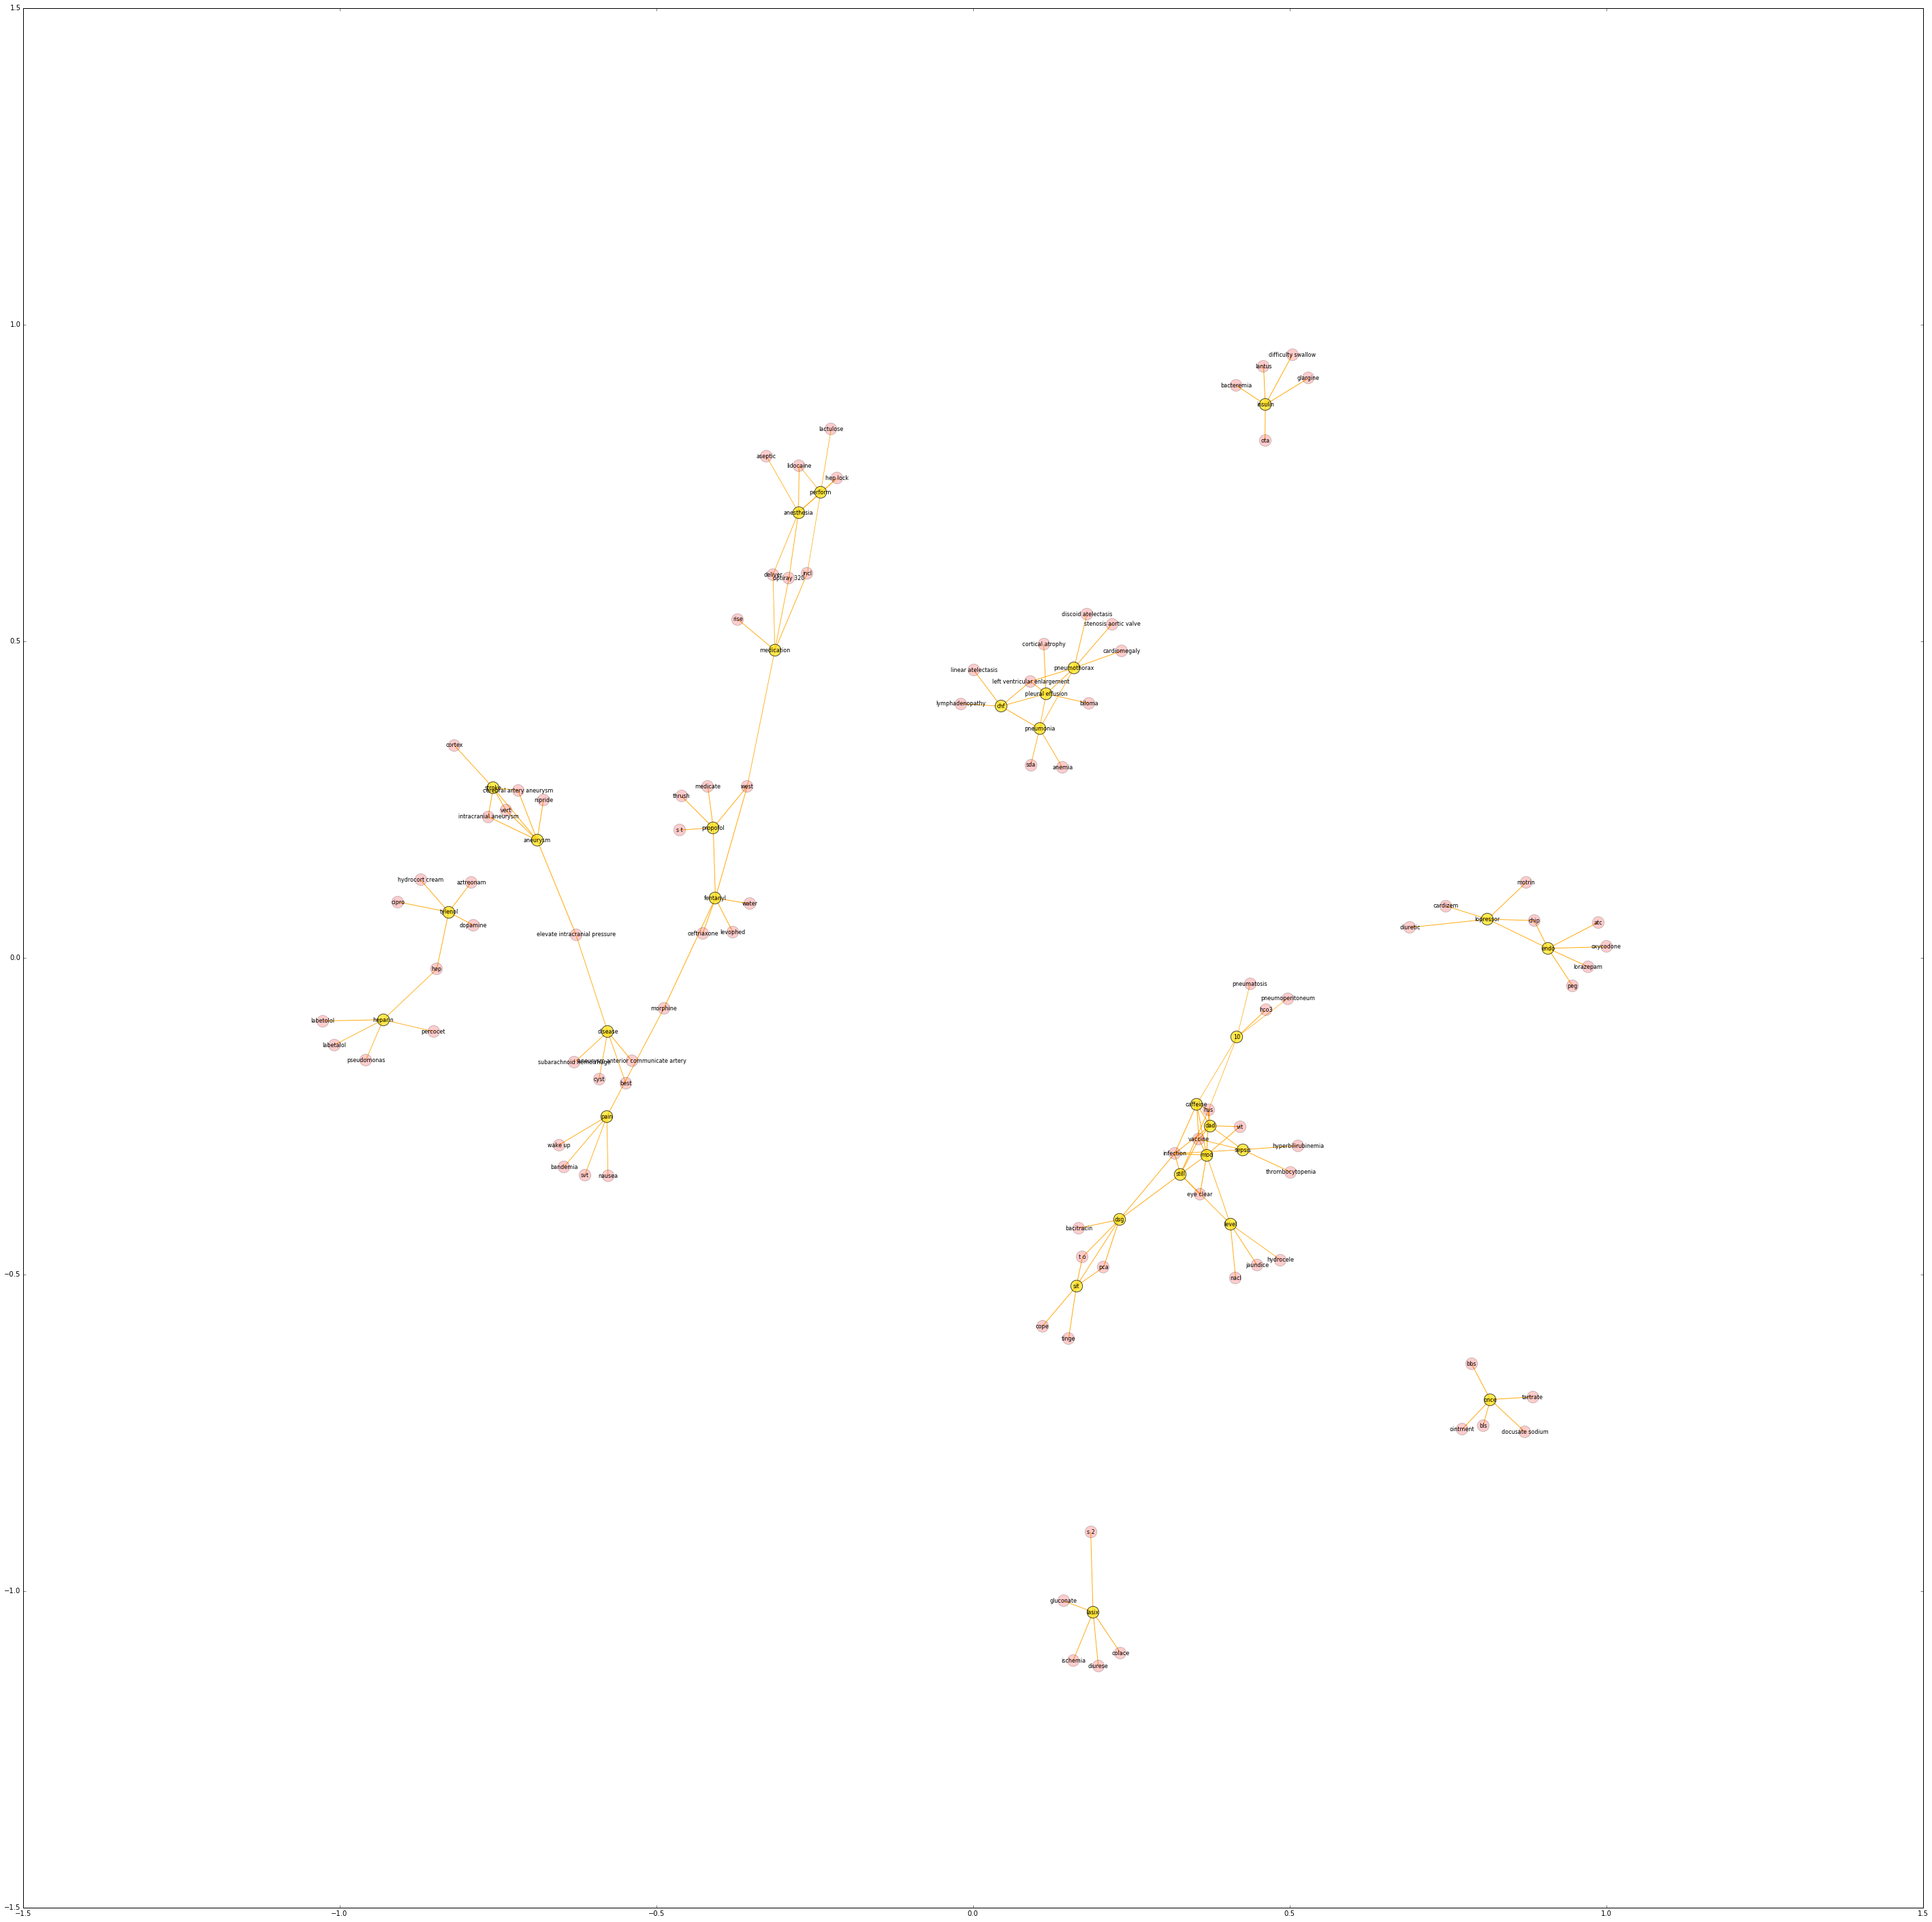

In [ ]:
new_notes = hc.sql("select noteid,concepts from strata.tmp_concepts2")

#train spark mllib word2vec on the dummy notes created
from pyspark.mllib.feature import Word2Vec
word2vec = Word2Vec()
word2vec.setVectorSize(100)
model = word2vec.fit(new_notes.rdd.map(lambda x: x.concepts))


def get_relevant_terms(term,cnt):
    synonyms=[]
    try:
        synonyms = model.findSynonyms(term, cnt)
    except Exception as e:
        pass
    return synonyms

# construct the represeantion of the graph of concept relationships derived from related terms obtained from word2vec
# by selecting the top 5 most relevant concepts where the releavncy is >0.5 for the most frequent diseases and drugs concepts
# having a frequency > 100 in the input 100 notes

import networkx as nx
G=nx.Graph()
d_d=set()

for term in disease_and_drugs[disease_and_drugs.freq>100].concept:
    rel = get_relevant_terms(term,5)
    for tup in rel:
        if tup[1]>0.5:
            G.add_edge(term,tup[0],weight=round(tup[1],2))
            d_d.add(term)
d_d_l=list(d_d)
try: 
    #pos = nx.graphviz_layout(G)
    pos = nx.spring_layout(G,iterations=50)
    plt.figure(figsize=(50,50))
    edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]
    nx.draw_networkx_nodes (G,pos,alpha=0.2,node_color='red',node_radius=20)
    nx.draw_networkx_nodes (G,pos,alpha=0.6,nodelist=d_d_l,node_color='yellow',node_radius=25)
    nx.draw_networkx_labels(G,pos,alpha=0.4,label_color='grey',font_size=8)
    nx.draw_networkx_edges(G,pos,edge_color='orange',width = edgewidth)
    plt.savefig("disease_drugs.png")
    plt.show()
except Exception as e: # matplotlib not available
    print e

#### Graph of relevant terms for the diseases and drugs extracted out of 100 MIMIC notes obtained from word2vec fitted on the initial 100 notes

#### Graph of relevant terms for the diseases and drugs extracted out of 100 MIMIC notes obtained from word2vec fitted on 1000 notes

Number of tokens in training set:  459502


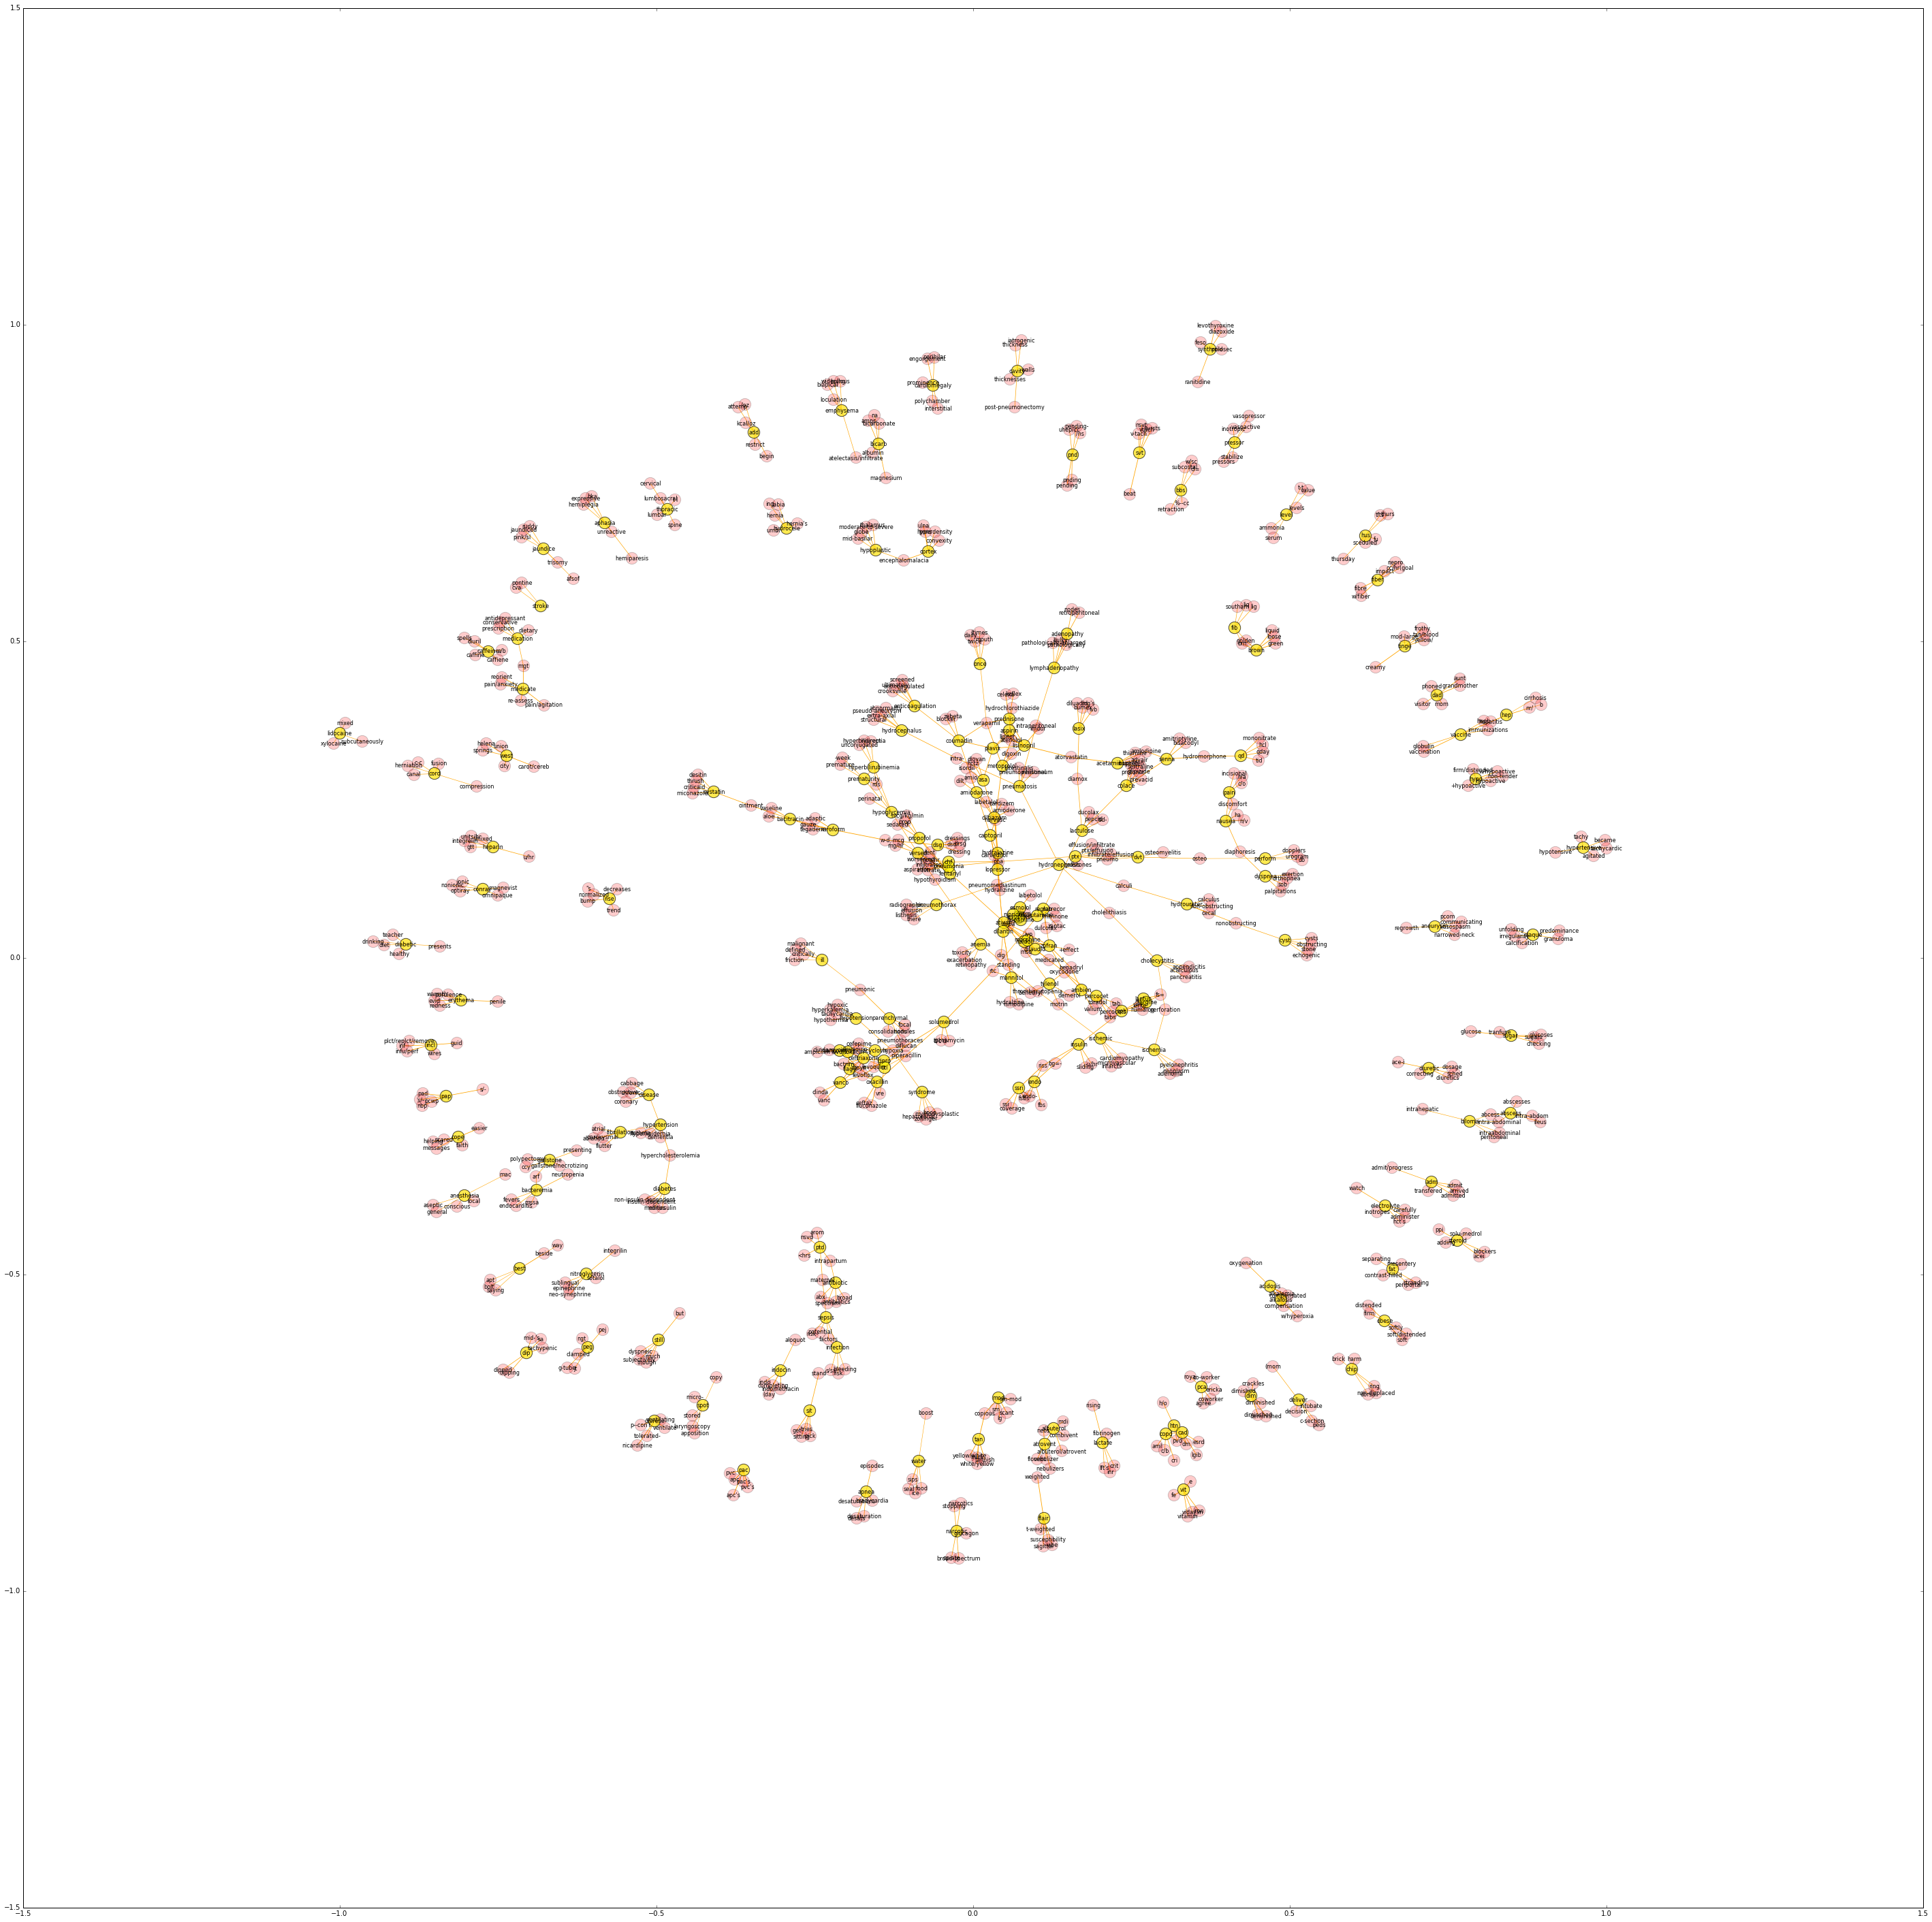

In [ ]:
from pyspark.mllib.feature import Word2Vec
def normalize(s):
    res = s.lower().replace('.',' ').replace(',',' ').replace(':',' ').replace('_','').replace('*','').replace('|',' ')
    res = res.replace(';',' ').replace('0','').replace('1','').replace('2','').replace('3','').replace('4','').replace('5','')
    res = res.replace('6','').replace('7','').replace('8','').replace('9','').replace('?',' ').replace('@',' ')
    return res

textfile = sc.textFile('/user/ubuntu/datasets/demoUser/mimic2-dummy-1000notes/clean/*')
word2vec_all = Word2Vec()
word2vec_all.setVectorSize(100)
model2 = word2vec_all.fit(textfile.map(lambda row:normalize(row).split(' ')))
print 'Number of tokens in training set: ',textfile.map(lambda row:row.split(' ')).count()
def get_relevant_terms2(term,cnt):
    synonyms=[]
    try:
        synonyms = model2.findSynonyms(term, cnt)
    except Exception as e:
        pass
    return synonyms
import networkx as nx
G=nx.Graph()
#G=nx.cubical_graph()
d_d=set()
for term in disease_and_drugs[disease_and_drugs.freq>10].concept:
    rel = get_relevant_terms2(term,5)
    for tup in rel:
        if tup[1]>0.5:
            G.add_edge(term,tup[0],weight=round(tup[1],2))
            d_d.add(term)
d_d_l=list(d_d)
try: 
    #pos = nx.graphviz_layout(G)
    pos = nx.spring_layout(G, iterations=50)
    plt.figure(figsize=(50,50))
    edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]
    nx.draw_networkx_nodes (G,pos,alpha=0.2,node_color='red',node_radius=20)
    nx.draw_networkx_nodes (G,pos,alpha=0.6,nodelist=d_d_l,node_color='yellow',node_radius=25)
    nx.draw_networkx_labels(G,pos,alpha=0.4,label_color='grey',font_size=8)
    nx.draw_networkx_edges(G,pos,edge_color='orange',width = edgewidth)
    plt.savefig("disease_drugs.png")
    plt.show()
except Exception as e:
    print e

#### Consotruct the list of relevant terms for the diseases and drugs concepts using word2vec fitted on 1000 notes to be used as "synonyms" in ElasticSearch

In [ ]:
syns = []
for term in disease_and_drugs[disease_and_drugs.freq>10].concept:
    rel = get_relevant_terms2(term,5)
    tmp =[term]
    for tup in rel:
        if tup[1]>0.5:
            tmp.append(tup[0])
    if len(tmp)>1:
        syns.append(','.join(tmp))
print syns

#### Create an ElasticSearch Index to use for querying the 1000 notes

In [ ]:
from xpatterns.elasticsearch.elasticsearchclient import ElasticSearchClient
ec = ElasticSearchClient()
rdd = sc.wholeTextFiles('/user/ubuntu/datasets/demoUser/mimic2-dummy-1000notes/clean/')
ec.create_index(indexName='mimic_1000_notes',synonyms=syns)
ec.add_documents_from_files(indexName='mimic_1000_notes',files=rdd)

deleting 'mimic_1000_notes' index...
 response: '{u'acknowledged': True}'
creating 'mimic_1000_notes' index...
 response: '{u'acknowledged': True}'

#### Search the 1000 notes for various related terms with/without using the "synonyms" analyzer

In [104]:
import json
def search(indexName,query):
    res = ec.es.search(index=indexName, q=query)
    print 'Result for query "'+str(query)+'" against index "'+indexName+'"'
    for hit in res['hits']['hits']:
        notename = hit['_source']['col0']
        notename = notename[notename.rindex('/')+1:]

        print notename+' -- '+str(round(hit['_score'],3))

search ('mimic_1000_notes',"query=chf&analyzer=standard") 
search ('mimic_1000_notes',"query=chf&analyzer=my_synonyms") 
search ('mimic_1000_notes',"query=pneumonia&analyzer=my_synonyms") 
print
print
search ('mimic_1000_notes',"query=pneumothoraces & analyzer=standard") 
search ('mimic_1000_notes',"query=pneumothoraces  & analyzer=my_synonyms") 
search ('mimic_1000_notes',"query=pneumothorax & analyzer=my_synonyms") 
search ('mimic_1000_notes',"query=pneumothorax & analyzer=standard") 

Result for query "query=chf&analyzer=standard" against index "mimic_1000_notes"
3030-merged.txt -- 0.028
3384-merged.txt -- 0.026
3522-merged.txt -- 0.026
3339-merged.txt -- 0.022
3246-merged.txt -- 0.021
3328-merged.txt -- 0.021
3329-merged.txt -- 0.02
3388-merged.txt -- 0.02
3108-merged.txt -- 0.019
3788-merged.txt -- 0.019
Result for query "query=chf&analyzer=my_synonyms" against index "mimic_1000_notes"
3030-merged.txt -- 0.023
3384-merged.txt -- 0.022
3522-merged.txt -- 0.021
3339-merged.txt -- 0.019
3246-merged.txt -- 0.018
3328-merged.txt -- 0.017
3887-merged.txt -- 0.013
3793-merged.txt -- 0.009
3191-merged.txt -- 0.007
3460-merged.txt -- 0.006
Result for query "query=pneumonia&analyzer=my_synonyms" against index "mimic_1000_notes"
3030-merged.txt -- 0.024
3522-merged.txt -- 0.023
3384-merged.txt -- 0.019
3246-merged.txt -- 0.019
3339-merged.txt -- 0.019
3328-merged.txt -- 0.017
3921-merged.txt -- 0.015
3887-merged.txt -- 0.011
3068-merged.txt -- 0.008
3399-merged.txt -- 0.007
